<img src="proyecto_final_portada.png" alt="Portada Proyecto Final" style="height: 600px; width:600px;"/>



El sector de las telecomunicaciones (telecom) en India está cambiando rápidamente, con la creación de más y más empresas de telecomunicaciones y muchos clientes decidiendo cambiar entre proveedores. "Churn" se refiere al proceso en el que los clientes o suscriptores dejan de utilizar los servicios o productos de una empresa. Comprender los factores que influyen en la retención de clientes como también lograr predecir la posibilidad de "churn" es crucial para que las empresas de telecomunicaciones mejoren la calidad de sus servicios y la satisfacción del cliente. Como científicos de datos en este proyecto, nuestro objetivo es explorar la compleja dinámica del comportamiento y la demografía de los clientes en el sector de las telecomunicaciones en India para predecir la "salida" o "churn" de los clientes, utilizando dos conjuntos de datos completos de cuatro importantes socios de telecomunicaciones: Airtel, Reliance Jio, Vodafone y BSNL:

- `telecom_demographics.csv` contiene información relacionada con la demografía de los clientes indios:

| Variable             | Descripción                                      |
|----------------------|--------------------------------------------------|
| `customer_id `         | Identificador único de cada cliente.             |
| `telecom_partner `     | El socio de telecomunicaciones asociado con el cliente.|
| `gender `              | El género del cliente.                      |
| `age `                 | La edad del cliente.                         |
| `state`                | El estado indio en el que se encuentra el cliente.|
| `city`                 | La ciudad en la que se encuentra el cliente.       |
| `pincode`              | El código PIN de la ubicación del cliente.          |
| `registration_event` | Cuando el cliente se registró con el socio de telecomunicaciones.|
| `num_dependents`      | El número de dependientes (por ejemplo, niños) que tiene el cliente.|
| `estimated_salary`     | El salario estimado del cliente.                 |

- `telecom_usage` contiene información sobre los patrones de uso de los clientes indios:

| Variable   | Descripción                                                  |
|------------|--------------------------------------------------------------|
| `customer_id` | Identificador único de cada cliente.                         |
| `calls_made` | El número de llamadas realizadas por el cliente.                    |
| `sms_sent`   | El número de mensajes de SMS enviados por el cliente.             |
| `data_used`  | La cantidad de datos utilizada por el cliente.                     |
| `churn`    | Variable binaria que indica si el cliente ha cancelado o no (1 = cancelado, 0 = no cancelado).|

---

#### Estructura del notebook:
##### 1. Importación de librerías y dependencias 


In [225]:
#Importamos las librerías princiaples
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### 2. Análisis exploratorio de los datos y variables relevantes


Leemos los datasets y procesamos los datos desde archivos locales .csv

In [226]:
#Lectura de los archivos .csv con pandas
df1 = pd.read_csv('telecom_demographics.csv')
df2 = pd.read_csv('telecom_usage.csv')

print(df1.shape, df2.shape)

(6500, 10) (6500, 5)


In [227]:
#Unimos los dos dataframes con la variable customer id
df_full = pd.merge(df1,df2,on='customer_id')
df_full.head(5)

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1


In [228]:
df_full.shape

(6500, 14)

El dataset tiene 6500 filas y 15 columnas luego del join

Análisis estadístico de las variables númericas del dataset

In [229]:
df_full.describe(exclude='O') 

,customer_id,age,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,121035.576923,46.108615,548955.907077,1.982308,85529.193385,49.789538,24.257846,5000.956308,0.200462
std,70353.990092,16.443712,259874.312026,1.404659,37545.639180,29.799221,14.650736,2940.611928,0.400377
min,47.000000,18.000000,100045.000000,0.000000,20001.000000,-10.000000,-5.000000,-969.000000,0.000000
25%,60125.750000,32.000000,321550.000000,1.000000,52905.000000,25.000000,12.000000,2493.750000,0.000000
50%,120470.500000,46.000000,550163.500000,2.000000,85286.500000,50.000000,25.000000,4975.500000,0.000000
75%,181420.750000,60.000000,775155.500000,3.000000,118817.500000,75.000000,37.000000,7504.250000,0.000000
max,243505.000000,74.000000,999740.000000,4.000000,149977.000000,108.000000,53.000000,10919.000000,1.000000


Algunos datos relevantes del análisis estadísitico de la distribución de los datos:
- La edad promedio de los clientes de 46 años. La edad mínima es 18 y la edad máxima es de 74

- Estimated salary como genralmente sucede con los salarios tiene una desviación estandar enorme, implicando un desbalance entre la distribución de los salarios. 

- Aparecen números negativos en el mínimo de llamadas hechas, sms enviados y en la cantidad de datos utilizados. Deberemos decidir como se interpretarán y usarán estos datos.



Análisis estadístico de las variables categóricas del dataset

In [230]:
df_full.describe(include='O').T

,count,unique,top,freq
telecom_partner,6500,4,Reliance Jio,1658
gender,6500,2,M,3909
state,6500,28,Karnataka,260
city,6500,6,Delhi,1128
registration_event,6500,1216,2021-04-04,14


El análisis de variables categóricas nos permite revisar la frecuencia y la cantidad de valores nulos:

 - No hay valroes nulos, tenemos 4 empresas, 2 géneros y con mayor frecuencia masculinos.
 
 - La ciudad con más frecuencia es Delhi, relacionada con el estado Karnataka. 


In [231]:
sns.set_palette('deep') #Seteamos la paleta de colores

In [232]:
def vars_categoricas_graf(dataframe, x, y): #Función que permite graficar variables categóricas y ver la cantidad de renuncias por categoría
        if x == y:
                churn_counts = dataframe[x].value_counts().reset_index()
                churn_counts = churn_counts.replace({0:'No', 1: 'Sí'})
                sns.barplot(data=churn_counts, x='churn', y='count', hue='churn', legend=False)
                plt.ylabel('Cantidad de bajas de clientes')
                plt.xlabel('¿El cliente se dió la baja?')
                plt.show()
                print(churn_counts)

                
        else:   
                grouped_df = df_full.groupby(x)[y].sum().reset_index() #agrupamos y sumamos para obtener la cantidad total de bajas por variable categórica

                plt.subplots(figsize=(8,6))
                sns.barplot(data=grouped_df, x=x, y=y, hue=x, legend=False) #graficamos
                plt.xticks(rotation=90)
                plt.xlabel('Tipos de '+ x + ' diferentes')
                plt.ylabel('Cantidad de bajas de clientes')
                plt.show()
                print('Top 5 variables con mas churn', '\n', '\n', grouped_df.sort_values(by=y, ascending=False).head(5))

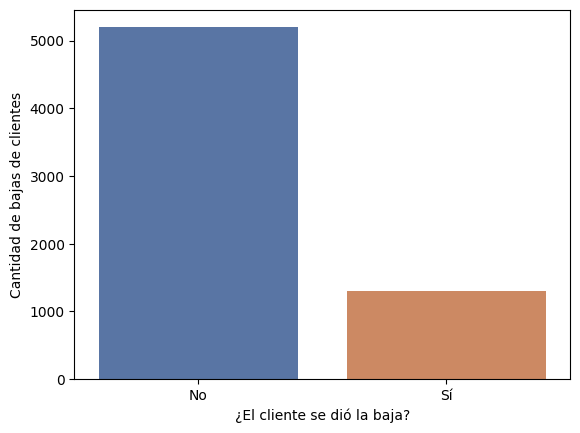

  churn  count
0    No   5197
1    Sí   1303


In [233]:
vars_categoricas_graf(df_full, 'churn', 'churn')

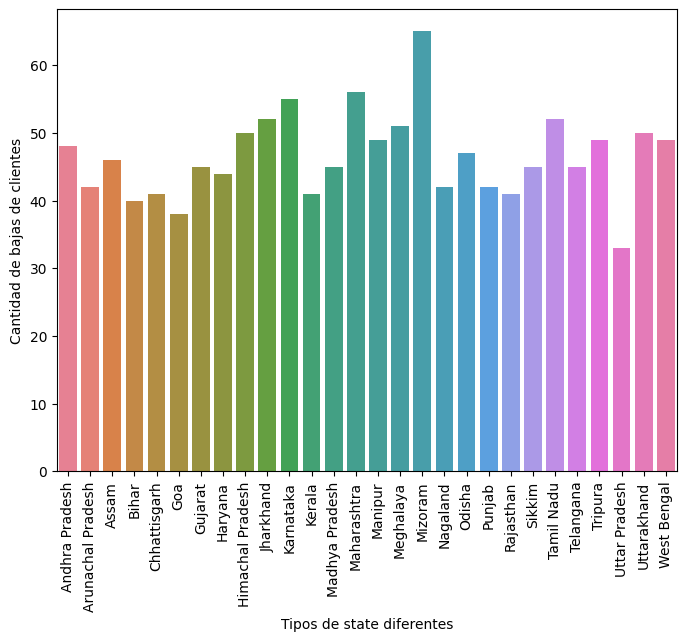

Top 5 variables con mas churn 
 
           state  churn
16      Mizoram     65
13  Maharashtra     56
10    Karnataka     55
22   Tamil Nadu     52
9     Jharkhand     52


In [234]:
vars_categoricas_graf(df_full, 'state', 'churn')

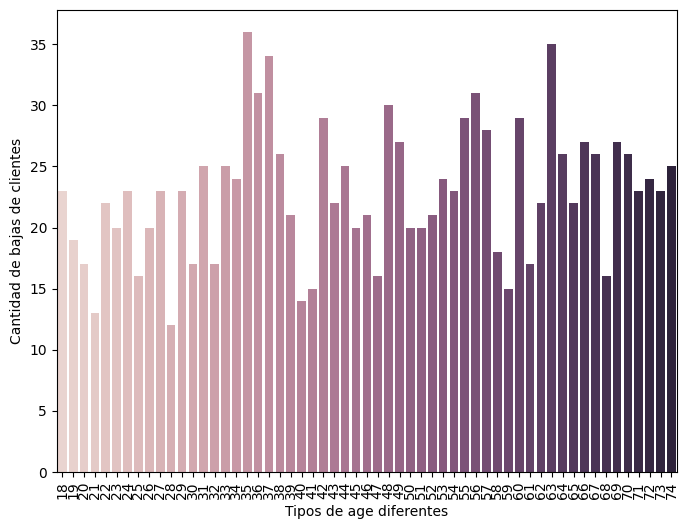

Top 5 variables con mas churn 
 
     age  churn
17   35     36
45   63     35
19   37     34
38   56     31
18   36     31


In [235]:
vars_categoricas_graf(df_full, 'age', 'churn')

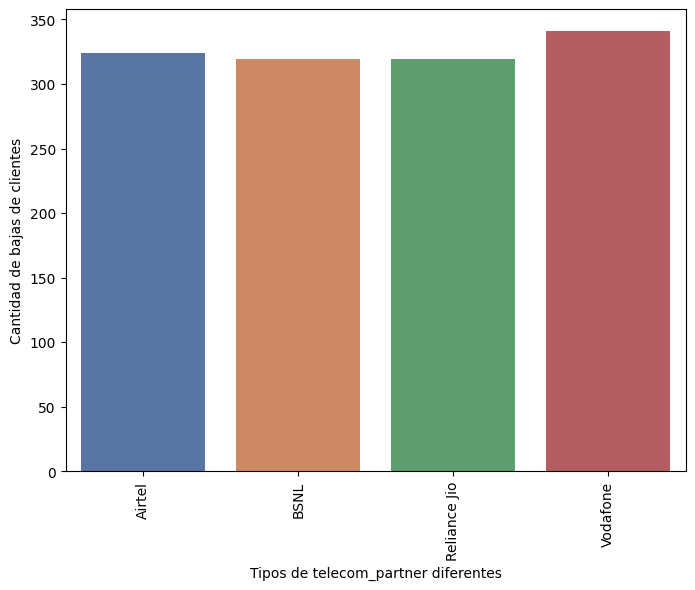

Top 5 variables con mas churn 
 
   telecom_partner  churn
3        Vodafone    341
0          Airtel    324
1            BSNL    319
2    Reliance Jio    319


In [236]:
vars_categoricas_graf(df_full, 'telecom_partner', 'churn')

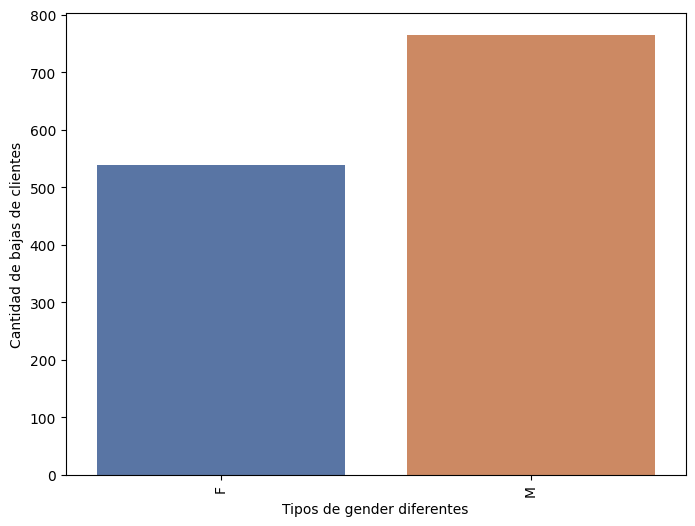

Top 5 variables con mas churn 
 
   gender  churn
1      M    765
0      F    538


In [237]:
vars_categoricas_graf(df_full, 'gender', 'churn')

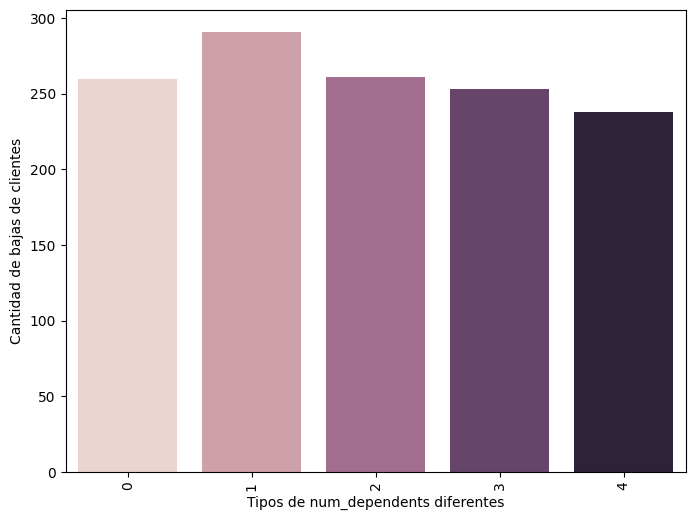

Top 5 variables con mas churn 
 
    num_dependents  churn
1               1    291
2               2    261
0               0    260
3               3    253
4               4    238


In [239]:
vars_categoricas_graf(df_full, 'num_dependents', 'churn')

Index(['customer_id', 'telecom_partner', 'gender', 'age', 'state', 'city',
       'pincode', 'registration_event', 'num_dependents', 'estimated_salary',
       'calls_made', 'sms_sent', 'data_used', 'churn', 'rango'],
      dtype='object')

In [ ]:
df_full.groupby('telecom_partner')['churn'].count()

telecom_partner
Airtel          1598
BSNL            1635
Reliance Jio    1658
Vodafone        1609
Name: churn, dtype: int64

In [ ]:
df_full.groupby('calls_made')['churn'].count().sort_values(ascending=False)[0:10]

calls_made
86    86
83    82
89    80
70    80
38    78
87    77
90    75
47    74
9     74
16    74
Name: churn, dtype: int64

(array([ 21.,  24.,  71.,  62.,  70., 144.,  98., 118., 193., 127., 139.,
        185., 138., 164., 130., 129., 193., 133., 124., 180., 133., 129.,
        195., 116., 136., 199., 123., 196., 137., 125., 185., 132., 133.,
        198., 113., 134., 184., 118., 181., 132., 149., 218., 135., 127.,
        146.,  74.,  76.,  95.,  28.,  10.]),
 array([-10.  ,  -7.64,  -5.28,  -2.92,  -0.56,   1.8 ,   4.16,   6.52,
          8.88,  11.24,  13.6 ,  15.96,  18.32,  20.68,  23.04,  25.4 ,
         27.76,  30.12,  32.48,  34.84,  37.2 ,  39.56,  41.92,  44.28,
         46.64,  49.  ,  51.36,  53.72,  56.08,  58.44,  60.8 ,  63.16,
         65.52,  67.88,  70.24,  72.6 ,  74.96,  77.32,  79.68,  82.04,
         84.4 ,  86.76,  89.12,  91.48,  93.84,  96.2 ,  98.56, 100.92,
        103.28, 105.64, 108.  ]),
 <BarContainer object of 50 artists>)

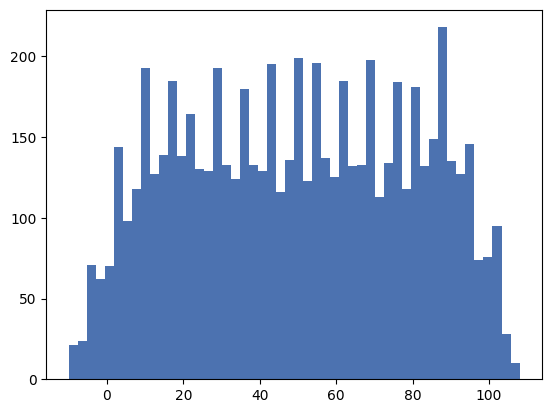

In [ ]:
plt.hist(df_full['calls_made'], bins=50)

In [ ]:
import seaborn as sns
import warnings 

In [ ]:
df_full['churn'].value_counts()

churn
0    5197
1    1303
Name: count, dtype: int64

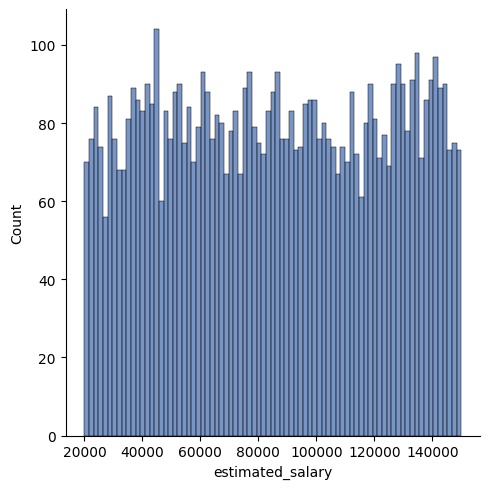

In [ ]:
sns.displot(df_full['estimated_salary'], bins=81)

In [ ]:
df_full.shape

(6500, 15)

In [ ]:
num_bins = 14

# Calcula los límites de los bins
bin_width = (max(df_full['estimated_salary']) - min(df_full['estimated_salary'])) / num_bins
bins = [min(df_full['estimated_salary']) + i * bin_width for i in range(num_bins + 1)]


In [ ]:
num_rangos = 20

# Calcula los límites de los rangos
rangos = pd.qcut(df_full['estimated_salary'], q=num_rangos, labels=False) + 1

# Crea una nueva columna con los valores de los rangos
df_full['rango'] = rangos

# Muestra el DataFrame resultante
df_full['rango']

0       11
1        8
2        9
3        3
4        2
        ..
6495    16
6496     7
6497     2
6498    16
6499    16
Name: rango, Length: 6500, dtype: int64

In [ ]:
rango_df = df_full.groupby('rango')['churn'].sum().reset_index()
rango_df 

,rango,churn
0,1,64
1,2,80
2,3,83
3,4,62
4,5,65
5,6,59
6,7,65
7,8,61
8,9,70
9,10,58


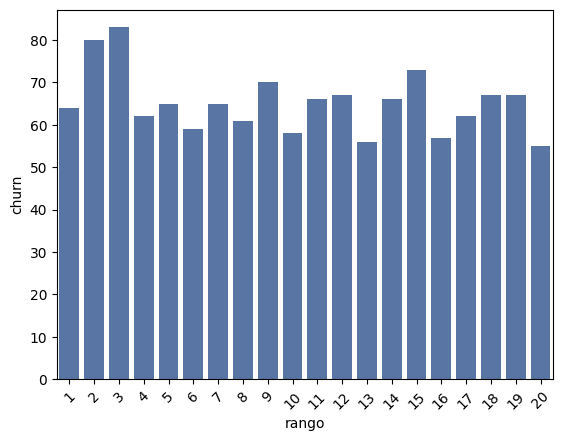

In [ ]:
sns.barplot(x=rango_df['rango'], y=rango_df['churn'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
age_df = df_full.groupby('age')['churn'].sum().reset_index().sort_values(by='churn', ascending=False).head(10)
age_df 

,age,churn
17,35,36
45,63,35
19,37,34
38,56,31
18,36,31
30,48,30
24,42,29
37,55,29
42,60,29
39,57,28


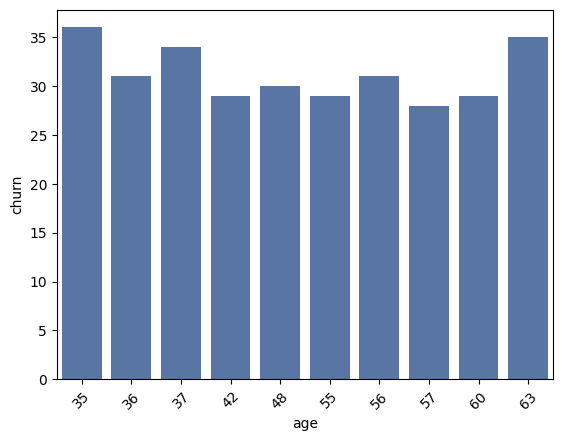

In [ ]:
sns.barplot(x=age_df['age'], y=age_df['churn'])
plt.xticks(rotation=45)
plt.show()


In [ ]:
df_full.columns

Index(['customer_id', 'telecom_partner', 'gender', 'age', 'state', 'city',
       'pincode', 'registration_event', 'num_dependents', 'estimated_salary',
       'calls_made', 'sms_sent', 'data_used', 'churn', 'rango'],
      dtype='object')